Find the optimal number of hidden neurons for the first depth and widths of the neural network designed in Question 1 and 2.

#### Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. Continue using 5-fold cross validation on the training dataset. Select the optimal number of neurons for the hidden layer. State the rationale for your selection. Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot. [optional + 2 marks] Implement an alternative approach that searches through these combinations that could significantly reduce the computational time but achieve similar search results, without enumeration all the possibilities.



This might take a while to run, approximately 30 - 60 min, so plan your time carefully.

1.Firstly, we import relevant libraries.

In [63]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from common_utils import set_seed

# setting seed
set_seed()

2.To reduce repeated code, place your

- network (MLP defined in QA1)
- torch datasets (CustomDataset defined in QA1)
- loss function (loss_fn defined in QA1)

in a separate file called **common_utils.py**

Import them into this file. You will not be repenalised for any error in QA1 here as the code in QA1 will not be remarked.

The following code cell will not be marked.

In [64]:
#reload common_utils to ensure the file is updated
import importlib
import common_utils
importlib.reload(common_utils)

<module 'common_utils' from 'c:\\Users\\65976\\Desktop\\SC4001 Assignment\\common_utils.py'>

In [65]:
from common_utils import MLP, CustomDataset, preprocess_dataset, EarlyStopper, preprocess


# binary classification
loss_fn = nn.BCELoss()

# Read dataset
df = pd.read_csv('simplified.csv')

# Create the label from the filename since filename contains the label
df['label'] = df['filename'].str.split('_').str[-2]

#Drop label and name
col_drop = ["filename", "label"]

# Preprocess the dataset by splitting and also scaling them 
X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df, col_drop= col_drop)

In [66]:
# Initialize the DataLoaders
def initialise_dataloader(X_train_scaled_fold, y_train_fold, X_val_scaled_fold, y_val_fold, batch_size):
    """
    Initializes DataLoaders for training and validation datasets.
    
    Args:
        X_train_scaled_fold (ndarray): Scaled input features for training for a fold.
        y_train_fold (ndarray): Training labels for a fold.
        X_val_scaled_fold (ndarray): Scaled input features for validation for a fold.
        y_val_fold (ndarray): Validation labels for a fold.
        batch_size (int): Batch size for loading the data.

    Returns:
        train_dataloader (DataLoader): DataLoader for the training set.
        validation_dataloader (DataLoader): DataLoader for the validation set.
    """
    # Create CustomDataset instances for training and validation
    train_dataset = CustomDataset(X_train_scaled_fold, y_train_fold)
    val_dataset = CustomDataset(X_val_scaled_fold, y_val_fold)

    # Create DataLoaders for training and validation
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    validation_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return train_dataloader, validation_dataloader

def training_loop(dataloader, model, loss_fn, optimizer):
    """
    Executes one epoch of training with the given model, DataLoader, and optimizer.
    
    Args:
        dataloader (DataLoader): DataLoader for training data.
        model (nn.Module): Neural network model to be trained.
        loss_fn (Loss Function): Loss function to calculate training loss.
        optimizer (Optimizer): Optimizer for updating model parameters.

    Returns:
        train_loss (float): Average training loss over the epoch.
        accuracy (float): Training accuracy as a percentage.
    """
    train_loss, correct_predictions = 0, 0
    total_samples = 0

    for _, (x, y) in enumerate(dataloader):
        # Forward pass
        pred = model(x)
        y = y.unsqueeze(1).float()

        # Calculate loss
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        predicted_labels = (pred > 0.5).float()
        correct_predictions += (predicted_labels == y).type(torch.float).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    accuracy = correct_predictions / total_samples
    return train_loss, accuracy

def validation_loop(dataloader, model, loss_fn):
    """
    Executes one epoch of validation with the given model and DataLoader.
    
    Args:
        dataloader (DataLoader): DataLoader for validation data.
        model (nn.Module): Neural network model to be evaluated.
        loss_fn (Loss Function): Loss function to calculate validation loss.

    Returns:
        val_loss (float): Average validation loss over the epoch.
        accuracy (float): Validation accuracy as a percentage.
    """
    val_loss, correct_predictions = 0, 0
    total_samples = 0

    with torch.no_grad():
        for x, y in dataloader:
            pred = model(x)
            y = y.unsqueeze(1).float()
            
            val_loss += loss_fn(pred, y).item()
            predicted_labels = (pred > 0.5).float()
            correct_predictions += (predicted_labels == y).type(torch.float).sum().item()
            total_samples += y.size(0)

    val_loss /= len(dataloader)
    accuracy = correct_predictions / total_samples
    return val_loss, accuracy


3.Perform hyperparameter tuning for the different neurons with 5-fold cross validation.

### Hyperparameters to Tune
- **Number of Layers**: 1, 2, or 3
- **Width of Hidden Layer**: 64, 128, or 256 neurons

Total 9 combination

### Model Complexity and Convergence
Larger hidden layer widths and increased model depths result in higher model complexity. To ensure that these complex models have sufficient opportunity to converge towards a global optimum, I will increase the **patience** and decrease the **min_delta** for early stopping. This approach gives the model more time to settle and reduces the risk of premature stopping before reaching optimal performance.

For models with **128 neurons** per hidden layer and a depth of **2 layers or more**, greater patience and a reduced min_delta will be applied. This configuration allows for the model's higher complexity and ensures adequate training time for stable convergence.

### Batch Size
The batch size used will be **256**, as determined in Task A2.



In [67]:
def train(model, X_train_scaled, y_train, X_val_scaled, y_val, batch_size, patience, min_delta):
    """
    Used to do the mini-batch training for each fold.

    Args:
        model: Model of to be use for this fold, with the appropriate depth and width
        X_train_scaled (ndarray): Scaled input features for training for a fold.
        y_train (ndarray): Training labels for a fold.
        X_val_scaled (ndarray): Scaled input features for testing for a fold.
        y_val (ndarray): Test labels for a fold.
        batch_size (int): Batch size for loading the data.
    
    Return: 
        train_accuracies: training accuracy for current fold.
        train_losses: training loss for current fold.
        test_accuracies: testing accuracy for current fold.
        test_losses: testing loss for current fold.
        times: time taken to train each epoch for current fold.
    """
    lr = 0.001
    no_epochs = 100
    train_dataloader, test_dataloader = initialise_dataloader(X_train_scaled, y_train, X_val_scaled, y_val, batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    early_stopper = EarlyStopper(patience=patience, min_delta=min_delta)

    train_accuracies, train_losses, test_accuracies, test_losses, times = [], [], [], [], []
    
    for epoch in range(no_epochs):
        #training
        start = time.time()
        train_loss_, train_acc_ = training_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss_, test_acc_ = validation_loop(test_dataloader, model, loss_fn)

        train_losses.append(train_loss_), train_accuracies.append(train_acc_)
        test_losses.append(test_loss_), test_accuracies.append(test_acc_)

        times.append(time.time() - start)
        if early_stopper.early_stop(test_loss_):
            print(f"Early Stop occur at epoch {epoch}")
            break
        
    print(f"\t\tTrain Acc: {train_acc_:.4f}\tTest Acc: {test_acc_:.4f}\tTrain Loss: {train_loss_:.4f}\tTest Loss: {test_loss_:.4f}\tTime: {times[-1]:.4f}")
    return train_accuracies, train_losses, test_accuracies, test_losses, times

In [68]:
def find_optimal_hyperparameter(X_train, y_train, num_neurons, num_layers, batch_size):
    """
    Perform 5-fold cross-validation for different combinations of neuron counts and hidden layers.

    The results are stored in a nested dictionary format:
    
    cross_validation_accuracies = {
        'train_acc': {
            (neurons, layers): {'data': [[fold_1_epoch_1, fold_1_epoch_2,...], ...]}, 
        },
        'train_loss': {
            (neurons, layers): {'data': [[fold_1_loss, fold_2_loss, ...]]},  
        },
        'test_acc': {
            (neurons, layers): {'data': [[fold_1_acc, fold_2_acc, ...]]},  
        },
        'test_loss': {
            (neurons, layers): {'data': [[fold_1_loss, fold_2_loss, ...]]}, 
        }
    }
    """
    
    # Initialize dictionaries for storing metrics
    cross_validation_accuracies, cross_validation_times = {}, {}
    
    train_acc_dict, test_acc_dict = {}, {}
    train_loss_dict, test_loss_dict = {}, {}

    # Iterate over number of layers
    for hidden_layer in num_layers:
        
        # Iterate over number of neurons for the first hidden layer
        for neuron_count in num_neurons:
            print(f"Processing {neuron_count} neurons in {hidden_layer} hidden layers...")

            # Initialize lists to store metrics for each fold
            training_acc_per_fold, test_acc_per_fold = [], []
            training_loss_per_fold, test_loss_per_fold = [], []
            time_taken_per_fold = []
            patience, min_delta = (10, 1e-4) if hidden_layer >= 2 and neuron_count >= 128 else (5, 0)

            # Perform 5-fold cross-validation
            kf = KFold(n_splits=5, shuffle=True, random_state=1)
            for fold_idx, (train_idx, test_idx) in enumerate(kf.split(X_train, y_train)):
                print(f"  Fold {fold_idx + 1}...")

                x_train, x_test = X_train[train_idx], X_train[test_idx]
                y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

                # Initialize model with specified depth and neuron count
                model = MLP(77, no_hidden=neuron_count, no_labels=1, depth=hidden_layer)

                # Train the model and collect metrics
                train_acc, train_loss, test_acc, test_loss, time_taken = train(
                    model, x_train, y_train_fold, x_test, y_test_fold, batch_size, patience, min_delta
                )

                # Store metrics for this fold
                training_acc_per_fold.append(train_acc)
                test_acc_per_fold.append(test_acc)
                training_loss_per_fold.append(train_loss)
                test_loss_per_fold.append(test_loss)
                time_taken_per_fold.append(time_taken)

            # Define key for current neuron/layer combination and store results
            key = (neuron_count, hidden_layer)
            train_acc_dict[key] = {'data': training_acc_per_fold}
            test_acc_dict[key] = {'data': test_acc_per_fold}
            train_loss_dict[key] = {'data': training_loss_per_fold}
            test_loss_dict[key] = {'data': test_loss_per_fold}
            cross_validation_times[key] = {'data': time_taken_per_fold}

    # Store all results in cross_validation_accuracies dictionary
    cross_validation_accuracies['train_acc'] = train_acc_dict
    cross_validation_accuracies['train_loss'] = train_loss_dict
    cross_validation_accuracies['test_acc'] = test_acc_dict
    cross_validation_accuracies['test_loss'] = test_loss_dict
    
    return cross_validation_accuracies, cross_validation_times


# Example usage
optimal_bs = 256
num_neurons = [64, 128, 256]
num_layers = [1, 2, 3]  
cross_validation_accuracies, cross_validation_times = find_optimal_hyperparameter(X_train_scaled, y_train, num_neurons, num_layers, optimal_bs)


Processing 64 neurons in 1 hidden layers...
  Fold 1...
Early Stop occur at epoch 28
		Train Acc: 0.7455	Test Acc: 0.6724	Train Loss: 0.5127	Test Loss: 0.6279	Time: 0.1579
  Fold 2...
Early Stop occur at epoch 26
		Train Acc: 0.7470	Test Acc: 0.6708	Train Loss: 0.5086	Test Loss: 0.6359	Time: 0.1458
  Fold 3...
Early Stop occur at epoch 20
		Train Acc: 0.7193	Test Acc: 0.6407	Train Loss: 0.5542	Test Loss: 0.6398	Time: 0.1442
  Fold 4...
Early Stop occur at epoch 19
		Train Acc: 0.7147	Test Acc: 0.6672	Train Loss: 0.5501	Test Loss: 0.6295	Time: 0.1601
  Fold 5...
Early Stop occur at epoch 31
		Train Acc: 0.7592	Test Acc: 0.6656	Train Loss: 0.5007	Test Loss: 0.6262	Time: 0.1492
Processing 128 neurons in 1 hidden layers...
  Fold 1...
Early Stop occur at epoch 20
		Train Acc: 0.7864	Test Acc: 0.6838	Train Loss: 0.4473	Test Loss: 0.6267	Time: 0.1872
  Fold 2...
Early Stop occur at epoch 31
		Train Acc: 0.8177	Test Acc: 0.6973	Train Loss: 0.3946	Test Loss: 0.6066	Time: 0.2101
  Fold 3...
Ear

4. Plot the mean cross-validation accuracies on the final epoch for at least 8 different combinations of different depth (limit to 1-3 layers) and widths (limit to 64, 128 or 256 neurons) using a scatter plot. 

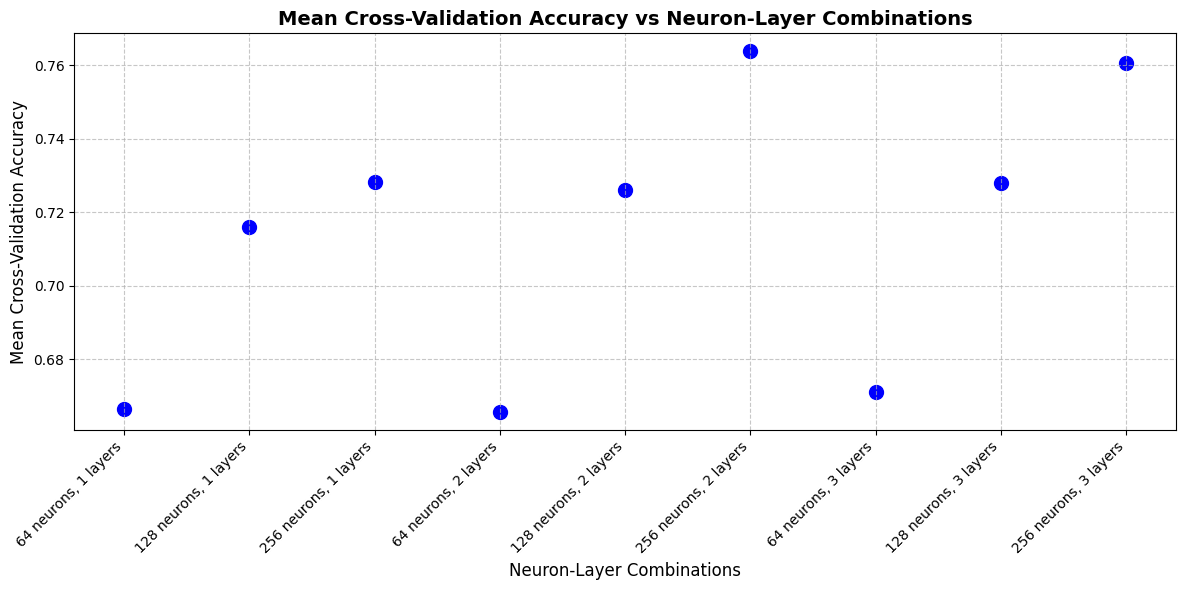

In [69]:
from itertools import chain
import matplotlib.pyplot as plt
import numpy as np

def plot_mean_accuracies(cross_validation_accuracies):
    neuron_layer_combinations = []
    mean_accuracies = []

    # Calculate the mean accuracy for each combination
    for (neurons, layers), values in cross_validation_accuracies['train_acc'].items():
        # Flatten the nested list and calculate mean accuracy
        flattened_values = list(chain(*values['data']))
        mean_accuracy = np.mean(flattened_values)

        # Append results for plotting
        combination_label = f'{neurons} neurons, {layers} layers'
        neuron_layer_combinations.append(combination_label)
        mean_accuracies.append(mean_accuracy)

    # Plot the mean accuracies
    plt.figure(figsize=(12, 6))
    plt.scatter(neuron_layer_combinations, mean_accuracies, color='blue', marker='o', s=100)
    plt.xlabel('Neuron-Layer Combinations', fontsize=12)
    plt.ylabel('Mean Cross-Validation Accuracy', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.title('Mean Cross-Validation Accuracy vs Neuron-Layer Combinations', fontsize=14, fontweight='bold')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Call the function to plot
plot_mean_accuracies(cross_validation_accuracies)


5. Select the optimal combination for the depth and width. State the rationale for your selection.

**Optimal Combination**: [2, 256]

**Reasoning**:
Based on the results, the optimal configuration is found to be 256 neurons with 2 layers. This combination achieves the highest mean cross-validation accuracy, as shown in the accuracy graph above.

A more complex architecture, such as the one with 256 neurons and 2 layers, generally enhances cross-validation accuracy. This is because a larger model can capture more intricate patterns within the data, thereby improving its generalization capabilities and resulting in higher accuracy.

However, if the model architecture is excessively complex for the given task, there is a risk of overfitting. In such cases, the model might tend to memorize patterns rather than generalize effectively to new data. Thus, while a more complex model offers better accuracy in this scenario, caution should be taken to avoid overfitting due to the model's increased capacity.


6.Plot the train and test accuracies against training epochs with the optimal number of neurons using a line plot.


In [71]:
def plot_accuracies_over_epochs(train_acc_dict, test_acc_dict, optimal_neurons, optimal_layers):
    key = (optimal_neurons, optimal_layers)  # Use the optimal configuration key

    # Flatten the list of lists for both train and test accuracy using chain
    train_accuracies_list = train_acc_dict[key]['data']
    test_accuracies_list = test_acc_dict[key]['data']

    # Ensure all folds have the same number of epochs by trimming or padding (if needed)
    min_epochs = min(len(fold) for fold in train_accuracies_list)
    train_accuracies_list = [fold[:min_epochs] for fold in train_accuracies_list]
    test_accuracies_list = [fold[:min_epochs] for fold in test_accuracies_list]

    # Calculate the mean training and testing accuracies across all folds
    train_accuracies = np.mean(train_accuracies_list, axis=0)
    test_accuracies = np.mean(test_accuracies_list, axis=0)

    # Create a range for epochs
    epochs = range(1, len(train_accuracies) + 1)  # Number of epochs

    # Plot the training and test accuracies over epochs
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_accuracies, label='Train Accuracy', color='blue', linestyle='-', marker='o')
    plt.plot(epochs, test_accuracies, label='Test Accuracy', color='orange', linestyle='--', marker='x')

    # Add labels and title
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Train and Test Accuracies for {optimal_neurons} Neurons, {optimal_layers} Layers')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


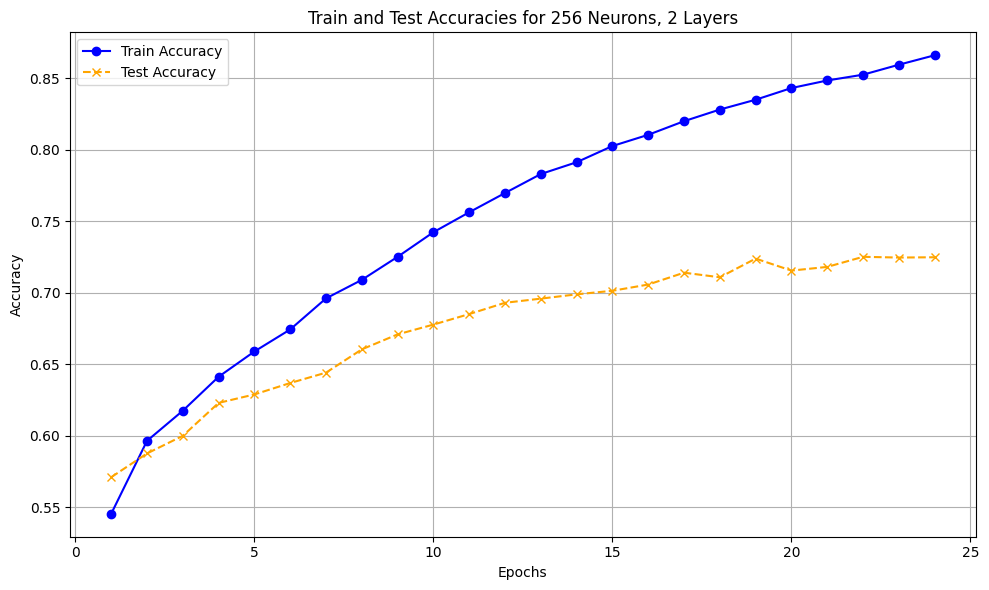

In [72]:
# Define the optimal configuration
optimal_neurons = 256
optimal_layers = 2

# Check if the specified configuration exists in the data before plotting
if (optimal_neurons, optimal_layers) in cross_validation_accuracies['train_acc'] and \
   (optimal_neurons, optimal_layers) in cross_validation_accuracies['test_acc']:
    
    plot_accuracies_over_epochs(
        cross_validation_accuracies['train_acc'], 
        cross_validation_accuracies['test_acc'], 
        optimal_neurons, 
        optimal_layers
    )
else:
    print(f"No data available for {optimal_neurons} neurons and {optimal_layers} layers.")


7.As you've astutely observed, we're facing a significant challenge in enumerating all possible combinations of widths and depths and searching over them. Given the circumstances, could you explore and implement a more efficient method for searching through these combinations that could significantly reduce the computational time but achieve similar search results?

In [89]:
import tempfile
import os

# Get the system's default temporary directory
os.environ["RAY_TMPDIR"] = tempfile.gettempdir()
